In [20]:
from main import *
import pandas as pd
import scipy

In [21]:
train, test, ytr, yte = gen_data(123456, 500, [1], 0.5, 0)

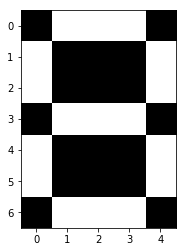

In [22]:
num_show(train[0])

In [23]:
from scipy.optimize import line_search

In [24]:
wt = np.random.normal(size = 35, scale = 0.1)[None, :]

In [25]:
from scipy.optimize import line_search
#from optinpy.optinpy.linesearch import interp23

In [3]:
from ls import linesearch
def GM(x, f, g, eps, kmax, precision = 6):
    gradient_norm = round(np.linalg.norm(g(x)), precision)
    Xk = [[np.NaN, f(x), gradient_norm]]
    rk = [np.NaN]
    Mk = [np.NaN]
    #==============#
    k = 0
    almax = 1
    while np.linalg.norm(g(x)) > eps and k < kmax:
        d = -g(x)
        if k != 0:
            almax = np.squeeze(2 * (f(x) - f(x_prev)) / (g(x).T @ d))
        alpha, iout = linesearch(f, g, x, d, alpham = almax, c1 = 0.01, c2 = 0.45, maxiter = 500, eps = 10e-6)
        x_prev = x
        x = x + alpha*d
        k += 1
        #===========#
        gradient_norm = np.round(np.linalg.norm(g(x)), precision)
        Xk.append([alpha, f(x), gradient_norm])
        rk.append(np.linalg.norm(g(x))/np.linalg.norm((g(x_prev))))
        Mk.append(np.linalg.norm(g(x))/(np.linalg.norm((g(x_prev)))**2))
        #===========#
    data = pd.DataFrame(Xk, columns=["alpha", "f(x)", "||g(x)||"], dtype=np.float)
    data['r'] = rk
    data['M'] = Mk
    return x, data

In [4]:
def BFGS(x, f, g, eps, kmax, precision = 6):
    gradient_norm = np.round(np.linalg.norm(g(x)), precision)
    Xk = [[np.NaN, f(x), gradient_norm]]
    rk = [np.NaN]
    Mk = [np.NaN]
    #===========#
    H = I = np.identity(len(g(x)))
    k = 0
    almax = 1
    while np.linalg.norm(g(x)) > eps and k < kmax:
        d = -H @ g(x)
        if k != 0:
            almax = np.squeeze(2 * (f(x) - f(x_prev)) / (g(x).T @ d))
            #almax = old_al * ((old_g.T) @ old_d) / (g(x).T @ d)
        #alpha, iout = linesearch(f, g, x, d, alpham = almax, c1 = 0.01, c2 = 0.45, maxiter = 50, eps = 10e-6)
        if k > 0:
            alpha, *_ = line_search(f, g, x, d, old_old_fval=f(x_prev), c1 = 0.01, c2 = 0.45)
        else:
            alpha, *_ = line_search(f, g, x, d, c1 = 0.01, c2 = 0.45)
        if alpha is None:
            print("Stopped because of alpha (!)")
            databfgs = pd.DataFrame(Xk, columns=["alpha", "f(x)", "||g(x)||"], dtype=np.float)
            databfgs['r'] = rk
            databfgs['M'] = Mk
            return x, databfgs
        old_g = g(x)
        old_d = d
        old_al = alpha
        x, x_prev = x + alpha*d, x
        s = x - x_prev
        y = g(x) - g(x_prev)
        y = y[None, :]
        rho = 1 / ((y).T @ s)
        H = (I - rho * s @ y.T) @ H @ (I - rho * y @ (s.T)) + rho * s @ s.T
        k += 1
        #===========#
        gradient_norm = np.round(np.linalg.norm(g(x)), precision)
        Xk.append([alpha, f(x), gradient_norm])
        rk.append(np.linalg.norm(g(x))/np.linalg.norm((g(x_prev))))
        Mk.append(np.linalg.norm(g(x))/(np.linalg.norm((g(x_prev)))**2))
        #===========#
    databfgs = pd.DataFrame(Xk, columns=["alpha", "f(x)", "||g(x)||"], dtype=np.float)
    databfgs['r'] = rk
    databfgs['M'] = Mk
    return x, databfgs

In [5]:
def CGM(x, f, g, eps, kmax, iCG, iRC, precision = 6):
    gradient_norm = round(np.linalg.norm(g(x)), precision)
    Xk = [[np.NaN, f(x), gradient_norm]]
    rk = [np.NaN]
    Mk = [np.NaN]
    #==============#
    d = -g(x)
    k = 0
    while np.linalg.norm(g(x)) > eps and k < kmax:
        if k != 0:
            almax = np.squeeze(2 * (f(x) - f(x_prev)) / (g(x).T @ d))
        alpha, iout = linesearch(f, g, x, d, 50, c1 = 0.01, c2 = 0.45, maxiter = 500, eps = 10e-6)
        x, x_prev = x + alpha*d, x
        # ============================================================================================================ #  
        # CGM variants
        if iCG == "FR":
            beta = (g(x).T @ g(x)) / (g(x_prev).T @ g(x_prev))
        elif iCG == "PR":
            beta = max(0, g(x).T @ (g(x) - g(x_prev)) / (g(x_prev).T @ g(x_prev)))
        else:
            raise TypeError("iCG should be FR (Fletcher-Reeves) or PR (Polak-Ribière)")
        # ============================================================================================================ # 
        # Restart conditions
        if iRC > 0 and nu is None:
            raise TypeError(f"nu is a necessary parameter with iRC equal to {iRC}")
        if (iRC == 1 and k % nu == 0 or
                iRC == 2 and g(x).T @ g(x_prev) / np.linalg.norm(g(x))**2 > nu or
                k == 0):
            d = -g(x)
        else:
            d = -g(x) + beta*d
        # ============================================================================================================ # 
        k += 1
        #===========#
        gradient_norm = np.round(np.linalg.norm(g(x)), precision)
        Xk.append([alpha, f(x), gradient_norm])
        rk.append(np.linalg.norm(g(x))/np.linalg.norm((g(x_prev))))
        Mk.append(np.linalg.norm(g(x))/(np.linalg.norm((g(x_prev)))**2))
        #===========#
    data = pd.DataFrame(Xk, columns=["alpha", "f(x)", "||g(x)||"], dtype=np.float)
    data['r'] = rk
    data['M'] = Mk
    return x, data

In [6]:
def y(X, w):
    """Evaluates a SLNN with weigths `w` """
    return sigmoid((sigmoid(X) @ w.T))

In [7]:
def g_loss(w, X, ytr, p=0):
    #return (2 * sigmoid(X) * ((y(X, w) - ytr) * y(X, w) * (1 - y(X, w))) + p*w).sum(axis=0)
    return np.squeeze(2 * sigmoid(X.T) @ ((y(X, w) - ytr) * y(X, w) * (1 - y(X, w))) + p*w.T)

In [8]:
#g_loss(np.full((1, 35), 2), train, ytr)

In [9]:
#g_loss(wt, train, ytr)

In [10]:
#opty = BFGS(wt, lambda w: loss(w, train, ytr, 30), lambda w: g_loss(w, train, ytr, 30), 1e-6, 500)

In [11]:
#opty

In [12]:
#num_show(opty)

In [13]:
#g_loss(opty, train, ytr)

In [14]:
#loss(opty, train, ytr)

In [15]:
#np.round(np.squeeze(y(train, opty)))

In [16]:
#np.squeeze(ytr)

In [17]:
def less(data):
    if len(data) < 10:
        return data
    data_out = data.head(5)
    data_out = data_out.append(data.tail(5))
    return data_out

#### Class

In [139]:
class SLNN:
    def __init__(self, n = 35):
        self.weights    = np.zeros((1, 35))
        self._trained = False
        self.out = None
        
    def train(self, optimizer, x, y, p = 0, epsilon=10e-6, kmax = 1000):
        if optimizer == "GM":
            self.weights, self.out = GM(self.weights, lambda w: loss(w, x, y, p), lambda w: g_loss(w, x, y, p), epsilon, kmax)
        elif optimizer == "CGM":
            self.weights, self.out =  CGM(self.weights, lambda w: loss(w, x, y, p), lambda w: g_loss(w, x, y, p), epsilon, kmax, "FR", 0)
        elif optimizer == "BFGS":
            self.weights, self.out = BFGS(self.weights, lambda w: loss(w, x, y, p), lambda w: g_loss(w, x, y, p), epsilon, kmax)
            print(self.out)
        else:
            raise ValueError("Invalid optimizer.")
        self.x, self.y, self.p = x, y, p
        self.optimizer = optimizer
        self._trained = True
            
    def predict(self, x):
        return np.round(y(x, self.weights))
    
    def accuracy(self, x, y):
        return 100 * np.sum(self.predict(x) == y) / len(y)
    
    def summary(self, Xte, yte):
        if not self._trained:
            print("Model is not trained yet")
        else:
            print(f"Single Layer Neural Network (SLNN)")
            print("-"*75)
            print(f"Input size:\t\t\t{len(np.squeeze(self.weights))}")
            print(f"Output size:\t\t\t1 (binary)")
            print("-"*75)
            print(f"Train data:\t\t\t{len(self.x)} observations")
            print(f"Chosen optimization routine:\t{self.optimizer}")
            print(f"Regularization parameter:\t{self.p}")
            print(f"Loss:\t\t\t\t{loss(self.weights, self.x, self.y, self.p)}")
            print(f"Training accuracy:\t\t{self.accuracy(self.x, self.y)}%")
            print(f"Test accuracy:\t\t\t{self.accuracy(Xte, yte)}%")
            print("-"*75)
            print("Gradient: \n", g_loss(self.weights, self.x, self.y, self.p))
            print("-"*75)
            num_show(self.weights)
            return self.out

Single Layer Neural Network (SLNN)
---------------------------------------------------------------------------
Input size:			35
Output size:			1 (binary)
---------------------------------------------------------------------------
Train data:			500 observations
Chosen optimization routine:	GM
Regularization parameter:	0
Loss:				9.149113476270594
Training accuracy:		98.6%
Test accuracy:			94.86%
---------------------------------------------------------------------------
Gradient: 
 [ 0.00763287 -0.09295857 -0.12139392 -0.20208507 -0.05734815 -0.24112008
  0.05372104 -0.02434171 -0.03876911 -0.21666789 -0.24852801 -0.02279227
 -0.0017461  -0.02426949 -0.16204628 -0.03906595 -0.25734013 -0.14489296
 -0.15743184  0.03364612 -0.25564692 -0.02506217 -0.09436931 -0.01998683
 -0.13349138 -0.16784354 -0.0295514  -0.01932105 -0.02406408 -0.10942633
 -0.01048636 -0.18372634 -0.13236543 -0.08516605 -0.03530699]
---------------------------------------------------------------------------


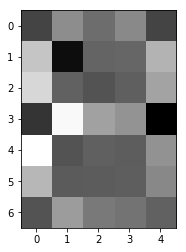

In [123]:
train, test, ytr, yte = gen_data(123456, 500, [8], 0.5, 0.1)
net = SLNN()
net.train("GM", train, ytr)
datagm = net.summary(test, yte)

In [125]:
less(datagm)

,alpha,f(x),||g(x)||,r,M
0,NaN,125.000000,23.498640,NaN,NaN
1,0.012545,121.438869,69.109355,2.940994,0.125156
2,0.001506,118.254841,27.115333,0.392354,0.005677
3,0.003138,117.113696,35.119194,1.295178,0.047766
4,0.001869,115.983980,27.143027,0.772883,0.022007
996,0.016728,9.160516,0.748599,1.280216,2.189362
997,0.010197,9.157672,0.581202,0.776386,1.037119
998,0.017010,9.154829,0.753820,1.297002,2.231586
999,0.010105,9.151970,0.577749,0.766429,1.016727
1000,0.017300,9.149113,0.759205,1.314073,2.274471


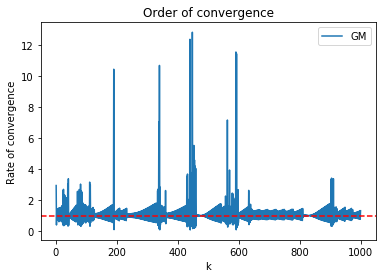

In [126]:
#plt.plot(datagm['||g(x)||'])
#plt.plot(datagm['r'])
#plt.plot(datagm['M'])
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm['r'], label = "GM")
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.show()

Single Layer Neural Network (SLNN)
---------------------------------------------------------------------------
Input size:			35
Output size:			1 (binary)
---------------------------------------------------------------------------
Train data:			500 observations
Chosen optimization routine:	CGM
Regularization parameter:	0
Loss:				6.640498856902224e-05
Training accuracy:		100.0%
Test accuracy:			94.38%
---------------------------------------------------------------------------
Gradient: 
 [ 1.57037960e-07 -5.15993848e-07 -2.51979707e-07 -4.09493612e-07
 -8.46613117e-08 -2.99155700e-06  4.78762156e-06  8.59580534e-08
 -9.94293613e-07 -2.93405157e-06 -1.59156194e-06  7.37128710e-07
 -2.61429570e-06 -9.84305279e-07 -3.17626172e-06  2.82194835e-07
 -4.46126255e-07 -7.75183310e-07 -1.68271266e-07  1.42375782e-07
  3.11586100e-06  1.25755726e-07 -1.23222807e-08 -1.97652704e-06
 -5.69778867e-07  8.00403291e-07  6.90101224e-07 -9.58539365e-07
  2.45260755e-06 -1.32194045e-06  9.76953817e-07 -1.1

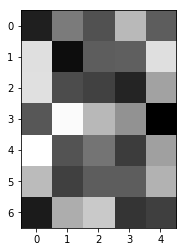

In [127]:
train, test, ytr, yte = gen_data(123456, 500, [8], 0.5, 0.1)
net = SLNN()
net.train("CGM", train, ytr)
datacgm = net.summary(test, yte)

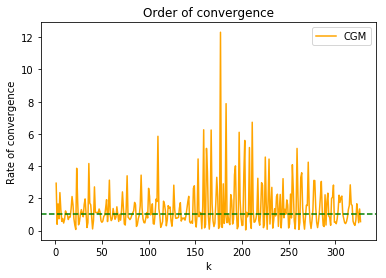

,alpha,f(x),||g(x)||,r,M
0,NaN,125.000000,23.498640,NaN,NaN
1,0.012545,121.438869,69.109355,2.940994,0.125156
2,0.001506,118.254841,27.115333,0.392354,0.005677
3,0.010094,113.755561,44.911436,1.656311,0.061084
4,0.003360,107.232204,32.831670,0.731031,0.016277
323,1024.000000,0.000069,0.000024,1.664724,116745.823587
324,1024.000000,0.000069,0.000027,1.140533,48046.807394
325,1024.000000,0.000067,0.000013,0.489425,18077.360084
326,1024.000000,0.000067,0.000018,1.342818,101339.794657
327,1024.000000,0.000066,0.000010,0.556389,31269.751249


In [132]:
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datacgm['r'], label = "CGM", color='orange')
plt.axhline(y=1, color='green', linestyle='--')
plt.legend()
plt.show()
less(datacgm)

          alpha        f(x)   ||g(x)||         r         M
0           NaN  125.000000  23.498640       NaN       NaN
1  1.254522e-02  121.438869  69.109355  2.940994  0.125156
2  1.019185e-09  118.630034  29.552085  0.427613  0.006187
3  4.751237e-16  118.464172  21.709071  0.734604  0.024858
Single Layer Neural Network (SLNN)
---------------------------------------------------------------------------
Input size:			35
Output size:			1 (binary)
---------------------------------------------------------------------------
Train data:			500 observations
Chosen optimization routine:	BFGS
Regularization parameter:	0
Loss:				118.46417176691992
Training accuracy:		83.4%
Test accuracy:			69.02%
---------------------------------------------------------------------------
Gradient: 
 [ 3.34755951 -2.75027427  1.53369366 -0.0117573   4.23008194 -4.08477929
  4.76065388  1.38514174  1.48382942 -4.20415297 -4.46852192  1.35253901
  3.00523672  2.55073946 -3.98047919  4.06434025 -7.99155245 -5.111536

,alpha,f(x),||g(x)||,r,M
0,NaN,125.000000,23.498640,NaN,NaN
1,1.254522e-02,121.438869,69.109355,2.940994,0.125156
2,1.019185e-09,118.630034,29.552085,0.427613,0.006187
3,4.751237e-16,118.464172,21.709071,0.734604,0.024858


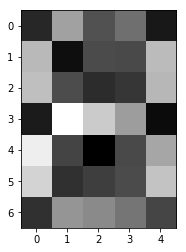

In [140]:
train, test, ytr, yte = gen_data(123456, 500, [8], 0.5, 0.1)
net = SLNN()
net.train("BFGS", train, ytr)
dataBFGS = net.summary(test, yte)
dataBFGS

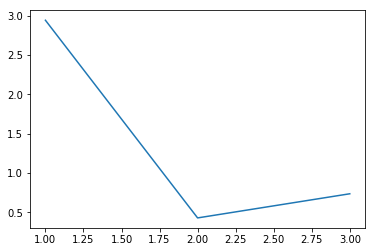

In [134]:
#plt.plot(data['||g(x)||'])
plt.plot(dataBFGS['r'])

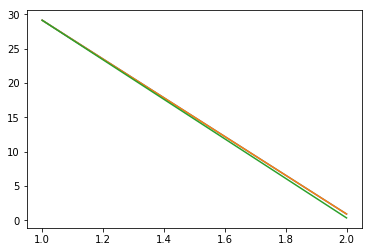

In [57]:
plt.plot(datagm['||g(x)||'][1:3])
plt.plot(datacgm['||g(x)||'][1:3])
plt.plot(dataBFGS['||g(x)||'][1:3])

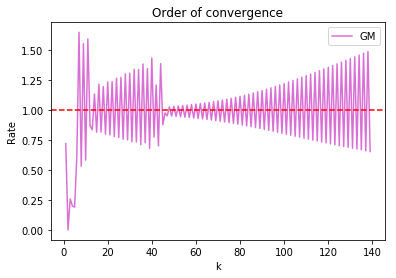

In [147]:
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm['r'], label = "GM", color = 'orchid')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.show()

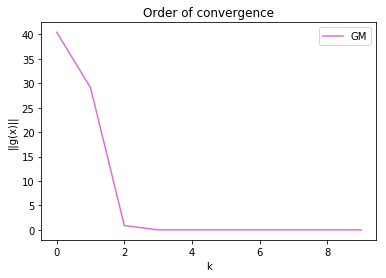

In [83]:
plt.figure()
plt.ylabel('||g(x)||')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm['||g(x)||'][0:10], label = "GM", color = 'orchid')
#plt.plot(datacgm['||g(x)||'], label = "CGM", color = 'turquoise')
#plt.plot(dataBFGS['||g(x)||'], label = "CGM", color = 'indigo')
plt.legend()
plt.show()

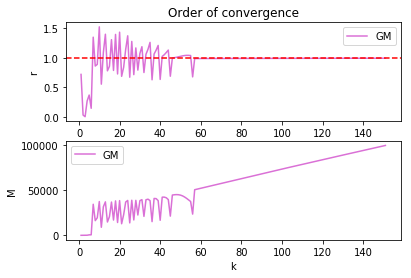

In [122]:
#import PyQt5
%matplotlib inline

fig = plt.figure()

plt.subplot(2, 1, 1)
pl.plot(datagm['r'], label = "GM", color = 'orchid')
plt.title('Order of convergence')
plt.axhline(y=1, color='r', linestyle='--')
plt.ylabel('r')
plt.xlabel('k')
pl.legend()

plt.subplot(2, 1, 2)
pl.plot(datagm['M'], label = "GM", color = 'orchid')
plt.ylabel('M')
plt.xlabel('k')
pl.legend()

plt.show()


In [211]:
#for i in range(1,len(datagm['r'])):
#    print('{:.2e}'.format(datagm['r'][i]))

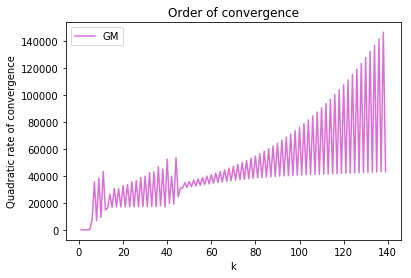

In [151]:
plt.figure()
plt.ylabel('Quadratic rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm['M'], label = "GM", color = 'orchid')
plt.legend()
plt.show()

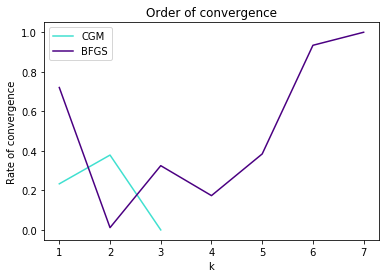

In [155]:
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datacgm['r'], label = "CGM", color = 'turquoise')
plt.plot(dataBFGS['r'], label = "BFGS", color = 'indigo')
plt.legend()
plt.show()

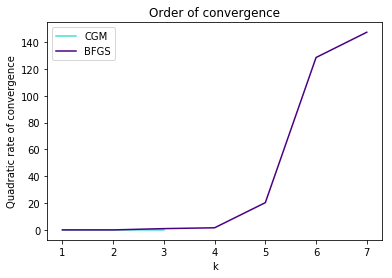

In [156]:
plt.figure()
plt.ylabel('Quadratic rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datacgm['M'], label = "CGM", color = 'turquoise')
plt.plot(dataBFGS['M'], label = "BFGS", color = 'indigo')
plt.legend()
plt.show()

In [157]:
datacgm

,alpha,f(x),||g(x)||,r,M
0,NaN,1.250000e+02,40.456701,NaN,NaN
1,3.1250,2.895490e+01,9.429834,2.330846e-01,5.761335e-03
2,1.5625,9.704749e-01,3.570048,3.785907e-01,4.014818e-02
3,3.1250,4.110602e-11,0.000000,8.413656e-11,2.356735e-11


Stopped because of alpha (!)
          alpha        f(x)   ||g(x)||         r         M
0           NaN  125.000000  22.986700       NaN       NaN
1  1.345997e-02  121.349491  70.268490  3.056919  0.132986
2  1.005002e-09  118.417573  28.741131  0.409019  0.005821
3  4.766201e-16  118.264986  21.227348  0.738570  0.025697
Single Layer Neural Network (SLNN)
---------------------------------------------------------------------------
Input size:			35
Output size:			1 (binary)
---------------------------------------------------------------------------
Train data:			500 observations
Chosen optimization routine:	BFGS
Regularization parameter:	0
Loss:				118.2649860882077
Training accuracy:		83.4%
Test accuracy:			70.28%
---------------------------------------------------------------------------
Gradient: 
 [ 3.64937388 -2.61744401  1.3802074  -0.05711023  3.72528981 -3.86640821
  4.80348817  1.56746746  1.21496839 -4.29214136 -3.97933385  1.21117907
  3.08375398  2.67328323 -3.56719826  3.80

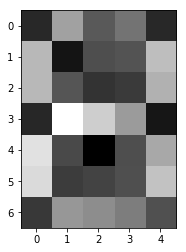

In [221]:
train, test, ytr, yte = gen_data(123456, 500, [8], 0.5, 0.1)
net = SLNN()
net.train("BFGS", train, ytr)
dataBFGS2 = net.summary(test, yte)

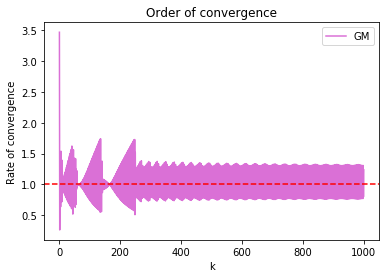

In [191]:
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm2['r'], label = "GM", color = 'orchid')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.show()

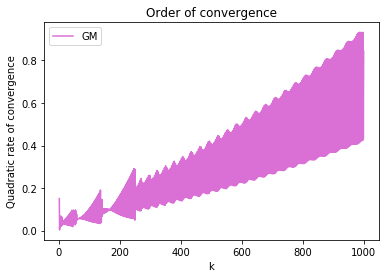

In [199]:
plt.figure()
plt.ylabel('Quadratic rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datagm2['M'], label = "GM", color = 'orchid')
plt.legend()
plt.show()

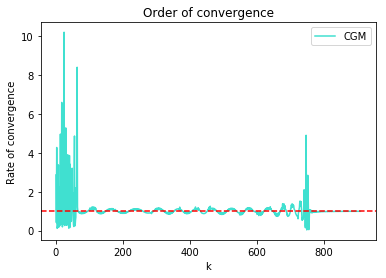

In [186]:
plt.figure()
plt.ylabel('Rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datacgm2['r'], label = "CGM", color = 'turquoise')
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.show()

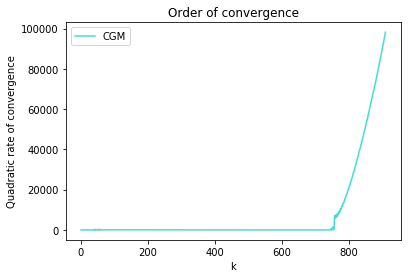

In [200]:
plt.figure()
plt.ylabel('Quadratic rate of convergence')
plt.xlabel('k')
plt.title('Order of convergence')
plt.plot(datacgm2['M'], label = "CGM", color = 'turquoise')
plt.legend()
plt.show()

#### Shared pixel values

In [4]:
shared = np.empty((10, 10))
for i, num in enumerate(nums):
    for j, num2 in enumerate(nums):
        shared[i, j] = np.sum(num + num2 == 2)

In [5]:
shared

array([[16.,  4.,  9., 12.,  7., 12., 11.,  5., 14., 13.],
       [ 4., 10.,  5.,  5.,  4.,  5.,  6.,  2.,  5.,  5.],
       [ 9.,  5., 14., 10.,  5.,  7.,  6.,  9., 10., 10.],
       [12.,  5., 10., 14.,  5., 10., 10.,  6., 14., 13.],
       [ 7.,  4.,  5.,  5., 15.,  6.,  9.,  4.,  7.,  6.],
       [12.,  5.,  7., 10.,  6., 17., 10.,  5., 11., 11.],
       [11.,  6.,  6., 10.,  9., 10., 16.,  4., 13., 11.],
       [ 5.,  2.,  9.,  6.,  4.,  5.,  4., 11.,  6.,  6.],
       [14.,  5., 10., 14.,  7., 11., 13.,  6., 17., 15.],
       [13.,  5., 10., 13.,  6., 11., 11.,  6., 15., 16.]])

In [6]:
np.sum(shared, axis = 0) - np.diag(shared)

array([87., 41., 71., 85., 53., 77., 80., 47., 95., 90.])